In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.impute import SimpleImputer
from sklearn.metrics import precision_score, recall_score, f1_score, roc_curve, auc, roc_auc_score, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from validation import compute_permutation_importance

# keras
import tensorflow as tf
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers

2023-09-04 20:13:32.409273: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [34]:
from sklearn.metrics import confusion_matrix
from sklearn.inspection import permutation_importance

In [10]:
# CDFS case
df_good1 = pd.read_csv('data/likely_matches_plane.csv')

df_good = df_good1.query("prob >= 0.95 and separation <= 0.2 and parallax == parallax and parallax >= 0")
df_bad = pd.read_csv('data/gaia_csc_cdfs.csv')
df_bad = df_bad.query("Separation != Separation and parallax == parallax and parallax >= 0")
df_all = pd.concat([df_good, df_bad], ignore_index=True)


In [59]:
df_bad.shape

(1785, 68)

In [3]:
# Rafael's case (with parallax)
df_good1 = pd.read_csv('data/likely_matches_plane.csv')

df_good = df_good1.query("prob >= 0.95 and separation <= 0.2 and parallax == parallax and parallax >= 0")
df_bad = pd.read_csv('data/unlikely_matches_plane.csv')
df_all = pd.concat([df_good, df_bad], ignore_index=True)


In [17]:
# Vinay's case
df_good_v = df_good1.query("prob >= 0.95 and separation <= 0.2 and parallax == parallax and parallax >= 0")

def create_bad_dataset(df, feature_names, shape):
    df_bad = df.sample(n=shape[0])

    # Features without corresponding error and over_error
    no_error_features = ['separation', 'bp_rp', 'bp_g', 'g_rp']

    # Randomly select values for features without corresponding error and over_error
    for feature in no_error_features:
        random_values = df[feature].sample(len(df), replace=True).reset_index(drop=True)
        df_bad[feature] = random_values

    # Features with corresponding error and over_error
    error_features = [feature for feature in feature_names if feature not in no_error_features]

    for feature in error_features:
        random_rows = df.sample(len(df), replace=True).reset_index(drop=True)
        df_bad[feature] = random_rows[feature]
        df_bad[feature + '_error'] = random_rows[feature + '_error']
        df_bad[feature + '_over_error'] = random_rows[feature + '_over_error']

    return df_bad

feature_names = [
    'separation', 
    'phot_g_mean_flux', 
    'phot_bp_mean_flux', 
    'phot_rp_mean_flux', 
    'bp_rp', 
    'bp_g', 
    'g_rp',
    'parallax'
]

# Apply the function to create the bad dataset
df_bad_v = create_bad_dataset(df_bad, feature_names, df_bad.shape)

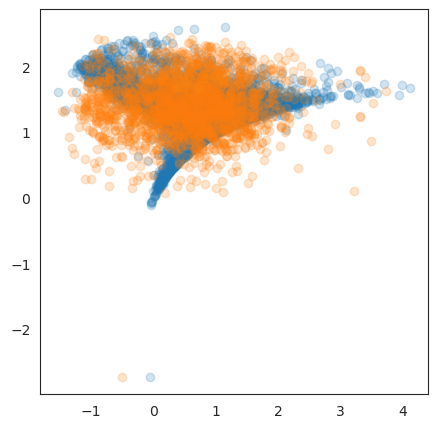

In [21]:
plt.scatter(df_good_v['bp_g'],df_good_v['g_rp'],alpha=0.2,)
plt.scatter(df_bad_v['bp_g'],df_bad_v['g_rp'],alpha=0.2)

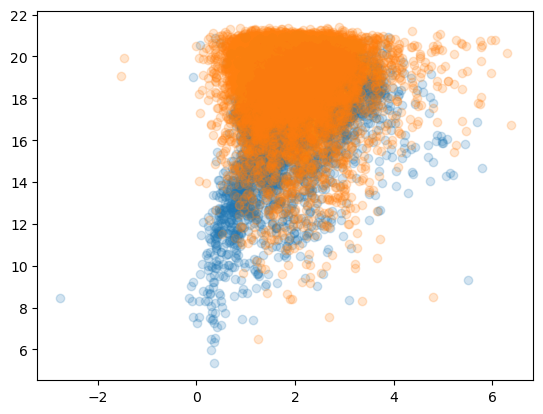

In [18]:
plt.scatter(df_good_v['bp_rp'],df_good_v['phot_g_mean_mag'],alpha=0.2,)
plt.scatter(df_bad_v['bp_rp'],df_bad_v['phot_g_mean_mag'],alpha=0.2)

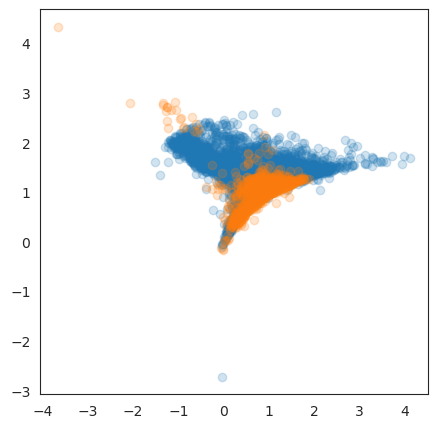

In [12]:
plt.scatter(df_good['bp_g'],df_good['g_rp'],alpha=0.2,)
plt.scatter(df_bad['bp_g'],df_bad['g_rp'],alpha=0.2)

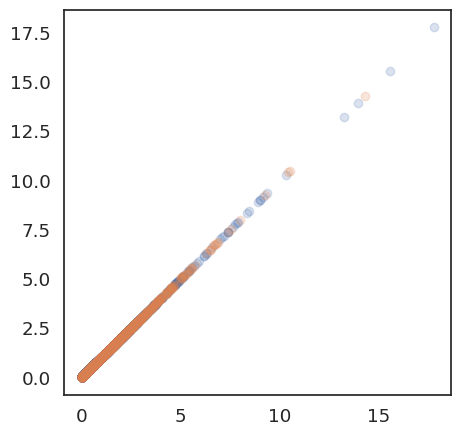

In [89]:
plt.scatter(df_good['parallax'],df_good['parallax'],alpha=0.2,)
plt.scatter(df_bad['parallax'],df_bad['parallax'],alpha=0.2)

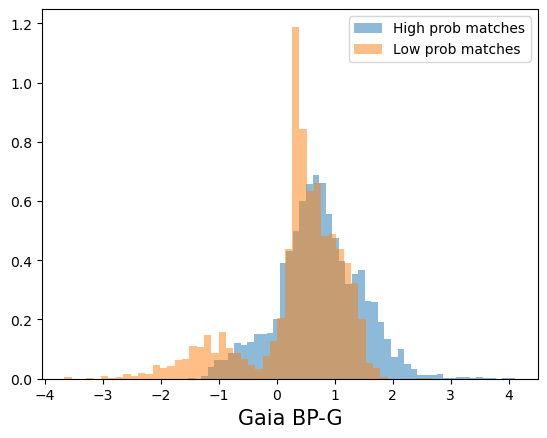

In [9]:
plt.hist(df_good['bp_g'],bins=50,alpha=0.5,density=True,label='High prob matches')
plt.hist(df_bad['bp_g'],bins=50,alpha=0.5,density=True,label='Low prob matches')
plt.xlabel('Gaia BP-G',size=15)
plt.legend()
#plt.savefig('figures/Gaia_BP_G.pdf',dpi=300)

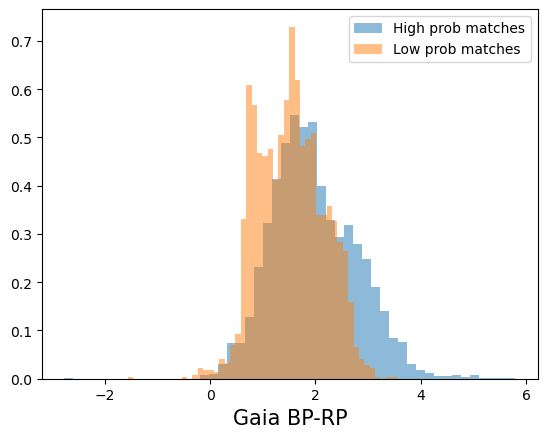

In [10]:
plt.hist(df_good['bp_rp'],bins=50,alpha=0.5,density=True,label='High prob matches')
plt.hist(df_bad['bp_rp'],bins=50,alpha=0.5,density=True,label='Low prob matches')
plt.xlabel('Gaia BP-RP',size=15)
plt.legend()
#plt.savefig('figures/Gaia_BP_RP.pdf',dpi=300)

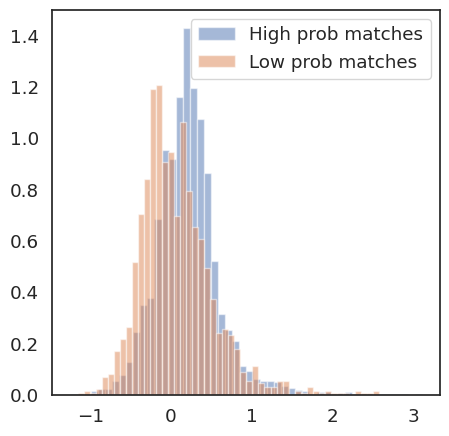

In [98]:
plt.hist(np.log10(1/df_good['parallax']),bins=50,alpha=0.5,density=True,label='High prob matches')
plt.hist(np.log10(1/df_bad['parallax']),bins=50,alpha=0.5,density=True,label='Low prob matches')
#plt.xlabel('Gaia G-RP',size=15)
plt.legend()
#plt.savefig('figures/Gaia_G_RP.pdf',dpi=300)

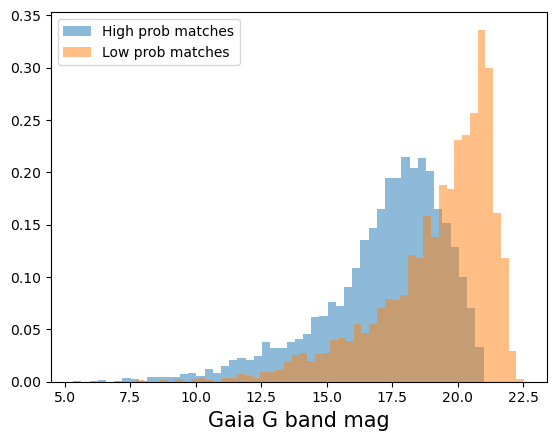

In [12]:
plt.hist(df_good['phot_g_mean_mag'],bins=50,alpha=0.5,density=True,label='High prob matches')
plt.hist(df_bad['phot_g_mean_mag'],bins=50,alpha=0.5,density=True,label='Low prob matches')
plt.xlabel('Gaia G band mag',size=15)
#plt.xscale('log')
plt.legend()
#plt.savefig('figures/Gaia_G_mag.pdf',dpi=300)

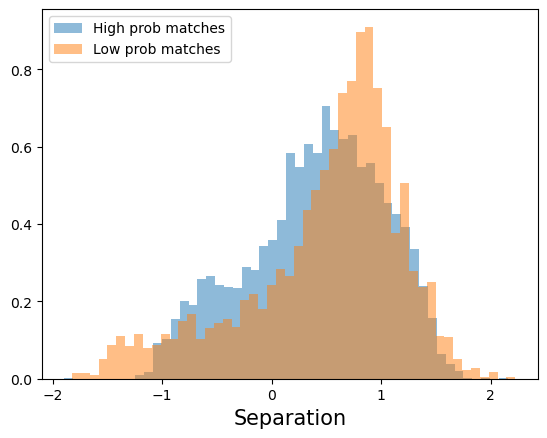

In [13]:
plt.hist(np.log10(100./df_good['phot_bp_mean_flux_over_error']),bins=50,alpha=0.5,density=True,label='High prob matches')
plt.hist(np.log10(100./df_bad['phot_bp_mean_flux_over_error']),bins=50,alpha=0.5,density=True,label='Low prob matches')
plt.xlabel('Separation',size=15)
#plt.xscale('log')
plt.legend()
#plt.savefig('figures/Gaia_G_mag.pdf',dpi=300)

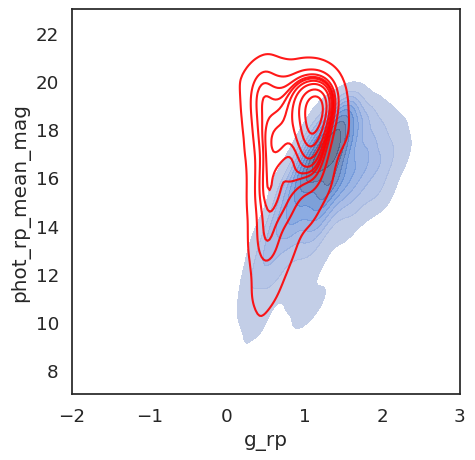

In [74]:
plt.rcParams['figure.figsize'] = 5, 5
sns.set_style("white")
sns.kdeplot(x=df_good.g_rp, y=df_good.phot_rp_mean_mag, label = 'High prob matches',fill=True,alpha=0.8)
sns.kdeplot(x=df_bad.g_rp, y=df_bad.phot_rp_mean_mag, label = 'Low prob matches',fill=False,alpha=0.9, color='red')
plt.xlim(-2,3)
plt.ylim(7,23)
# plt.xlabel('Gaia BP-G',size=15)
# plt.ylabel('Gaia G mag',size=15)
plt.savefig('figures/contour_with_mags_942023.pdf',dpi=300)

/tmp/ipykernel_28930/935819563.py:5: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  plt.xlim(0,10e3)
/tmp/ipykernel_28930/935819563.py:6: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  plt.ylim(0,10e3)


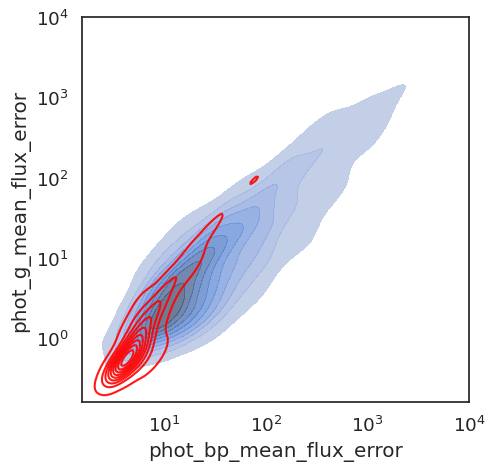

In [88]:
plt.rcParams['figure.figsize'] = 5, 5
sns.set_style("white")
sns.kdeplot(x=df_good.phot_bp_mean_flux_error, y=df_good.phot_g_mean_flux_error, label = 'High prob matches',fill=True,alpha=0.8, log_scale=True)
sns.kdeplot(x=df_bad.phot_bp_mean_flux_error, y=df_bad.phot_g_mean_flux_error, label = 'Low prob matches',fill=False,alpha=0.9, log_scale=True, color='red')
plt.xlim(0,10e3)
plt.ylim(0,10e3)
plt.savefig('figures/contour_g_bp_flux_errors.pdf', dpi=300)

Text(0, 0.5, 'Gaia G mag')

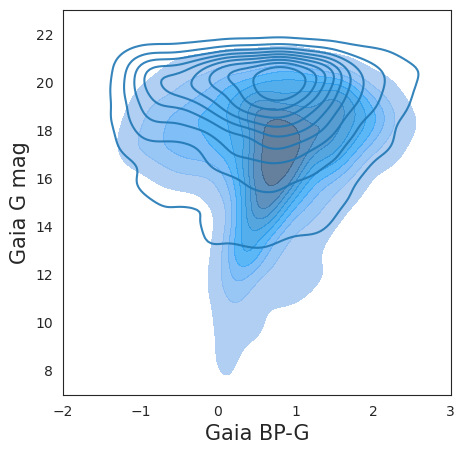

In [21]:
plt.rcParams['figure.figsize'] = 5, 5
sns.set_style("white")
sns.kdeplot(x=df_good_v.bp_g, y=df_good_v.phot_g_mean_mag, label = 'High prob matches',fill=True,alpha=0.8)
sns.kdeplot(x=df_bad_v.bp_g, y=df_bad_v.phot_g_mean_mag, label = 'Low prob matches',fill=False,alpha=0.9)
plt.xlim(-2,3)
plt.ylim(7,23)
plt.xlabel('Gaia BP-G',size=15)
plt.ylabel('Gaia G mag',size=15)

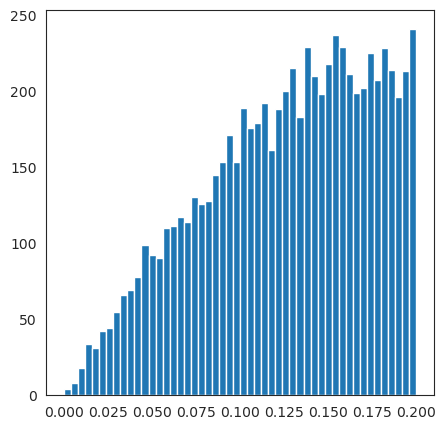

In [49]:
plt.hist(df_good['separation'],bins=50)
plt.show()

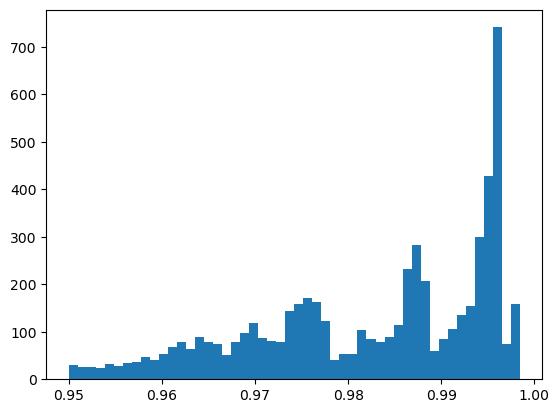

In [6]:
plt.hist(df_good['prob'],bins=50)
plt.show()

---
#### Preprocessing

In [75]:
feature_names = [ 
    'phot_g_mean_flux', 
    'phot_g_mean_flux_error', 
    'phot_g_mean_flux_over_error', 
    'phot_bp_mean_flux', 
    'phot_bp_mean_flux_error', 
    'phot_bp_mean_flux_over_error', 
    'phot_rp_mean_flux', 
    'phot_rp_mean_flux_error', 
    'phot_rp_mean_flux_over_error', 
    'bp_rp', 
    'bp_g', 
    'g_rp',
    'parallax', 
    'parallax_over_error'
]

# List of features to skip for the log transformation
skip_log_features = ['bp_rp', 'bp_g', 'g_rp']

## Random Feature
# Add random values to the DataFrame
# r = np.random.RandomState(42)
# df_good['random_feature'] = r.rand(len(df_good))
# df_bad['random_feature'] = r.rand(len(df_bad))

# # Add the random feature name to the feature names list
# feature_names.append('random_feature')
# skip_log_features.append('random_feature')

def transform_features(df):
    transformed_features = [
        np.log10(df[feature].values) if feature not in skip_log_features else df[feature].values
        for feature in feature_names
    ]
    return np.array(transformed_features).T

def preprocess(df_good, df_bad):
    # Transform features
    X_good = transform_features(df_good)
    X_bad = transform_features(df_bad)

    # Concatenate X and create Y labels
    X = np.concatenate((X_good, X_bad), axis=0)
    Y = np.concatenate((np.ones(len(X_good)), np.zeros(len(X_bad))), axis=0)

    return X, Y

def handle_missing_values(X_train, X_test):
    imp_mean = SimpleImputer(missing_values=np.nan, strategy='mean')
    X_train = imp_mean.fit_transform(X_train)
    X_test = imp_mean.transform(X_test)
    return X_train, X_test

def standardize(X_train, X_test):
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    return X_train_scaled, X_test_scaled

In [76]:
# Preprocess the data
X, Y = preprocess(df_good, df_bad)
indices = np.arange(X.shape[0])

# Split into training and test sets
(X_train, 
 X_test, 
 Y_train, 
 Y_test, 
 indices_train, 
 indices_test) = train_test_split(X, Y, indices, test_size=0.3, random_state=42, shuffle=True)

# Handle missing values
X_train, X_test = handle_missing_values(X_train, X_test)

# Standardize
X_train, X_test = standardize(X_train, X_test)

In [77]:
print(X_train.shape, X_test.shape)

(5284, 14) (2265, 14)


In [78]:
from collections import Counter

def class_proportions(y):
    counts = Counter(y)
    total = len(y)
    proportions = {key: value / total for key, value in counts.items()}
    return proportions

train_proportions = class_proportions(Y_train)
test_proportions = class_proportions(Y_test)

print("Training proportions:", train_proportions)
print("Test proportions:", test_proportions)

Training proportions: {1.0: 0.7592732778198334, 0.0: 0.24072672218016655}
Test proportions: {0.0: 0.22649006622516557, 1.0: 0.7735099337748345}


In [17]:
num_samples = X.shape[0]
nan_count_per_feature = np.isnan(X).sum(axis=0)

# Calculate the percentage for each feature
nan_percentage_per_feature = (nan_count_per_feature / num_samples) * 100

for i, percentage in enumerate(nan_percentage_per_feature):
    print(f"Percentage of NaN values in feature {feature_names[i]}: {percentage:.2f}%")


Percentage of NaN values in feature phot_g_mean_flux: 0.00%
Percentage of NaN values in feature phot_g_mean_flux_error: 0.00%
Percentage of NaN values in feature phot_g_mean_flux_over_error: 0.00%
Percentage of NaN values in feature phot_bp_mean_flux: 9.06%
Percentage of NaN values in feature phot_bp_mean_flux_error: 9.06%
Percentage of NaN values in feature phot_bp_mean_flux_over_error: 9.06%
Percentage of NaN values in feature phot_rp_mean_flux: 9.06%
Percentage of NaN values in feature phot_rp_mean_flux_error: 9.06%
Percentage of NaN values in feature phot_rp_mean_flux_over_error: 9.06%
Percentage of NaN values in feature bp_rp: 9.10%
Percentage of NaN values in feature bp_g: 9.06%
Percentage of NaN values in feature g_rp: 9.06%
Percentage of NaN values in feature parallax: 0.00%
Percentage of NaN values in feature parallax_over_error: 0.00%


---
#### Baseline Models

In [ ]:
# Model Building
clf = LogisticRegression(max_iter=10000)  # max_iter may need to be increased depending on data convergence
clf.fit(X_train, Y_train)

# Predictions
y_pred = clf.predict(X_test)
y_pred_prob = clf.predict_proba(X_test)[:, 1]  # for AUC

# Evaluation
print("Accuracy:", accuracy_score(Y_test, y_pred))
print("Precision:", precision_score(Y_test, y_pred))
print("Recall:", recall_score(Y_test, y_pred))
print("F1 Score:", f1_score(Y_test, y_pred))
print("AUC-ROC:", roc_auc_score(Y_test, y_pred_prob))

#feature_importances = clf.coef_[0]
#for i, imp in enumerate(feature_importances):
#    print(f"{feature_names[i]}: Coefficient = {imp:.4f}")

In [79]:
# Model Building
clf_rf = RandomForestClassifier(n_estimators=100, random_state=42, min_samples_leaf=20)
clf_rf.fit(X_train, Y_train)

# Predictions
y_pred_rf = clf_rf.predict(X_test)
y_pred_rf_prob = clf_rf.predict_proba(X_test)[:, 1]  # for AUC

# Evaluation
print("Accuracy:", accuracy_score(Y_test, y_pred_rf))
print("Precision:", precision_score(Y_test, y_pred_rf))
print("Recall:", recall_score(Y_test, y_pred_rf))
print("F1 Score:", f1_score(Y_test, y_pred_rf))
print("AUC-ROC:", roc_auc_score(Y_test, y_pred_rf_prob))

Accuracy: 0.9916114790286976
Precision: 0.9920499716070414
Recall: 0.9971461187214612
F1 Score: 0.9945915172217479
AUC-ROC: 0.9982715381808147


In [80]:
print(f"RF train accuracy: {clf_rf.score(X_train, Y_train):.3f}")
print(f"RF test accuracy: {clf_rf.score(X_test, Y_test):.3f}")

RF train accuracy: 0.987
RF test accuracy: 0.992


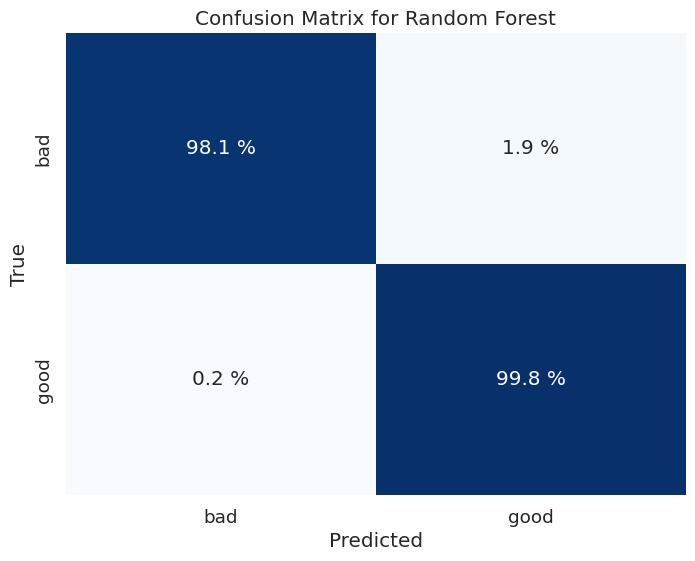

In [20]:
# Compute the confusion matrix and normalize it to get percentages
cm = confusion_matrix(Y_test, y_pred_rf, normalize='true')

# Multiply by 100 to get percentages and round to 1 decimal place
cm_percentage = (cm * 100).round(1)

# Define the class labels
class_labels = ['bad', 'good']

# Create a Seaborn heatmap
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2) # Adjust to your preference
sns.heatmap(cm_percentage, annot=True, fmt='', cmap='Blues', cbar=False, 
            xticklabels=class_labels, yticklabels=class_labels,
            annot_kws={'va':'center'},
            )

# Add labels and title
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix for Random Forest')

# Iterate through the heatmap to add the '%' sign to the annotations
for t in plt.gca().texts:
    t.set_text(t.get_text() + " %")

plt.savefig('figures/confusion_rf_.png', dpi=300)

In [ ]:
# Concatenate good and bad datasets to refer back later
df_test = df_all.iloc[indices_test]

# Add predictions and actual labels
df_test['prediction'] = y_pred_rf
df_test['actual'] = Y_test

#df_test = df_test.query('separation <=0.2 and parallax >=0')
# Define categories based on predictions and actual labels
# df_test['category'] = df_test.apply(lambda row: 'true good' if row['prediction'] == row['actual'] == 1 else 
#                                                   'true bad' if row['prediction'] == row['actual'] == 0 else 
#                                                   'false good' if row['prediction'] == 1 else 'false bad', axis=1)

# df_test['category'] = df_test.apply(lambda row: 'true good' if row['prediction'] == row['actual'] == 1 else 
#                                                   'false bad' if row['prediction'] == 0 and row['actual'] == 1 else None, axis=1)

df_test['category'] = df_test.apply(lambda row: 'true bad' if row['prediction'] == row['actual'] == 0 else 
                                                  'false good' if row['prediction'] == 1 and row['actual'] == 0 else None, axis=1)

# Plot
plt.rcParams['figure.figsize'] = 5, 5
sns.set_style("white")


sns.scatterplot(data = df_test, x='g_rp', y='phot_g_mean_flux', 
            hue='category')
plt.yscale('log')

plt.show()


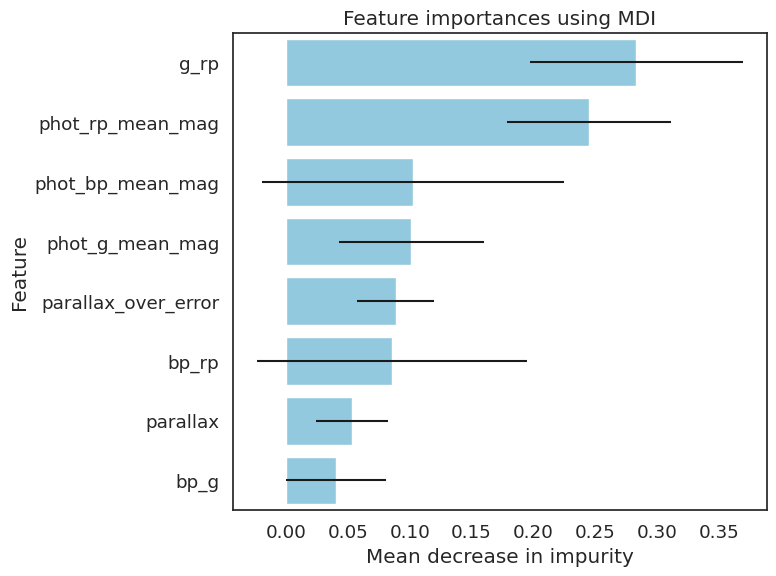

In [67]:
importances = clf_rf.feature_importances_
std = np.std([tree.feature_importances_ for tree in clf_rf.estimators_], axis=0)
forest_importances = pd.Series(importances, index=feature_names).sort_values(ascending=False)

# Create a DataFrame to allow Seaborn plotting
importance_df = pd.DataFrame({'Feature': forest_importances.index, 'Importance': forest_importances.values})

plt.figure(figsize=(8, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df, xerr=std, color='skyblue')
plt.title("Feature importances using MDI")
plt.xlabel("Mean decrease in impurity")
plt.tight_layout()
#plt.savefig('figures/importances_rf_8202023.pdf', dpi=300)

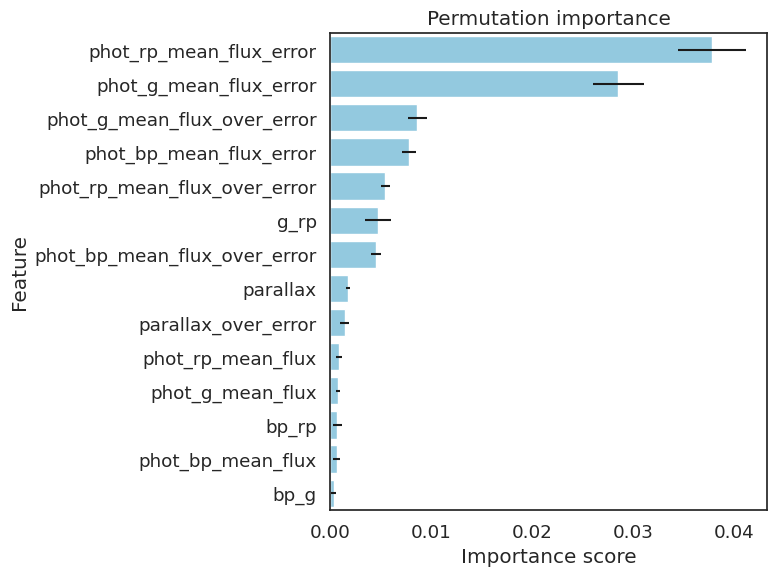

In [83]:
# Calculate permutation importances
per_importances = permutation_importance(
    clf_rf, X_test, Y_test, n_repeats=10, random_state=42, n_jobs=2
)

# Sort the features by importance in descending order
sorted_idx = per_importances.importances_mean.argsort()[::-1]

# Create a Pandas DataFrame for plotting
importance_df = pd.DataFrame({
    'Feature': np.array(feature_names)[sorted_idx],
    'Importance': per_importances.importances_mean[sorted_idx],
    'Importance_std': per_importances.importances_std[sorted_idx]
})

# Plot using Seaborn
plt.figure(figsize=(8, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df, color='skyblue', errorbar=None, capsize=.1, xerr=importance_df['Importance_std'])

# Add labels and title
plt.title("Permutation importance")
plt.xlabel("Importance score")
plt.tight_layout()
plt.savefig('importances_rf_942023.pdf')


In [ ]:
# Model Building
clf_svm = SVC(kernel='linear', probability=True, random_state=42)  # Using 'linear' kernel as a baseline. Probability is True for AUC-ROC.
clf_svm.fit(X_train, Y_train)

# Predictions
y_pred_svm = clf_svm.predict(X_test)
y_pred_svm_prob = clf_svm.predict_proba(X_test)[:, 1]  # for AUC

# Evaluation
print("Accuracy:", accuracy_score(Y_test, y_pred_svm))
print("Precision:", precision_score(Y_test, y_pred_svm))
print("Recall:", recall_score(Y_test, y_pred_svm))
print("F1 Score:", f1_score(Y_test, y_pred_svm))
print("AUC-ROC:", roc_auc_score(Y_test, y_pred_svm_prob))

#### NN

In [19]:
network = models.Sequential()
network.add(layers.Dense(128, activation='relu', input_shape=(15,)))
network.add(layers.Dense(64, activation='relu', input_shape=(128,)))
network.add(layers.Dense(1, activation='sigmoid'))

In [20]:
Adagrad = optimizers.Adagrad(learning_rate=0.005)
network.compile(optimizer=Adagrad,
                loss='binary_crossentropy',
                metrics=['binary_accuracy'])
#optimizer.lr.set_value(0.02)

In [22]:
history = network.fit(X_train, Y_train, validation_split=0.2, epochs=200, batch_size=256, verbose=False)

In [23]:
network.save('models/model2_2082023.h5')

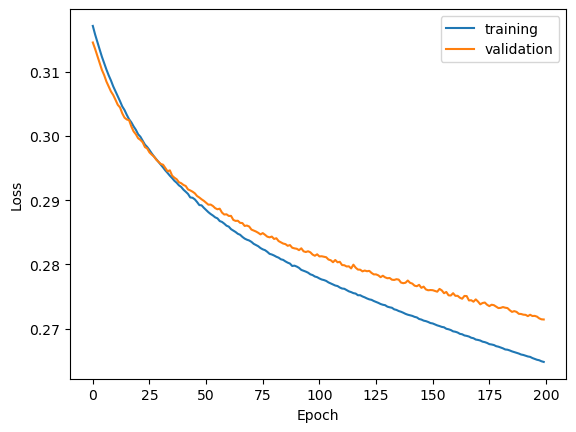

In [24]:
# 200, don't stop until overtfit. 
plt.plot(history.history['loss'],label='training')
plt.plot(history.history['val_loss'],label='validation')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
#plt.savefig('models/loss_nn2_random.pdf')

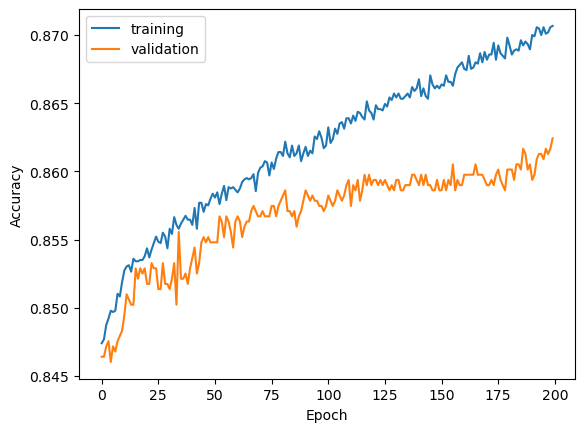

In [25]:
plt.plot(history.history['binary_accuracy'],label='training')
plt.plot(history.history['val_binary_accuracy'],label='validation')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
#plt.savefig('figures/acc_nn2_random.pdf')

In [26]:
print('\n# Evaluate on test data')
results = network.evaluate(X_test, Y_test, batch_size=256)
print('test loss, test acc:', results)


# Evaluate on test data
22/22 [==============================] - 0s 8ms/step - loss: 0.2668 - binary_accuracy: 0.8645
test loss, test acc: [0.26681530475616455, 0.8644610643386841]


In [27]:
# Predict probabilities for the test set
y_pred_probs = network.predict(X_test).ravel()

# Convert probabilities to class labels (0 or 1) using a threshold, typically 0.5 for binary classification
y_pred_label = (y_pred_probs > 0.5).astype(int)

# Compute precision, recall, and F1 score
precision = precision_score(Y_test, y_pred_label)
recall = recall_score(Y_test, y_pred_label)
f1 = f1_score(Y_test, y_pred_label)

# Compute ROC Curve and AUC
fpr, tpr, thresholds = roc_curve(Y_test, y_pred_probs)
roc_auc = auc(fpr, tpr)

# Display metrics
print('\n# Extended Evaluation Metrics')
print('Precision:', precision)
print('Recall:', recall)
print('F1 Score:', f1)
print('AUC:', roc_auc)


176/176 [==============================] - 1s 5ms/step

# Extended Evaluation Metrics
Precision: 0.7455310199789695
Recall: 0.8360849056603774
F1 Score: 0.7882156753752084
AUC: 0.9414277638673959


In [32]:
# Compute permutation importance
importances = compute_permutation_importance(clf_rf, X_test, Y_test)

# Display the importances
for i, imp in enumerate(importances):
    print(f"{feature_names[i]}: Importance = {imp:.4f}")

phot_g_mean_flux: Importance = 0.0000
phot_g_mean_flux_error: Importance = 0.1347
phot_g_mean_flux_over_error: Importance = 0.0053
phot_bp_mean_flux: Importance = 0.0000
phot_bp_mean_flux_error: Importance = 0.0053
phot_bp_mean_flux_over_error: Importance = 0.0044
phot_rp_mean_flux: Importance = -0.0004
phot_rp_mean_flux_error: Importance = 0.0291
phot_rp_mean_flux_over_error: Importance = 0.0035
bp_rp: Importance = 0.0004
bp_g: Importance = 0.0009
g_rp: Importance = 0.0031
parallax: Importance = 0.0013
parallax_over_error: Importance = 0.0009


In [ ]:
nn_importances = pd.Series(importances, index=feature_names).sort_values(ascending=False)

# Create a DataFrame to allow Seaborn plotting
importance_df = pd.DataFrame({'Feature': nn_importances.index, 'Importance': nn_importances.values})

plt.figure(figsize=(8, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df, color='skyblue')
plt.title("Feature importances using permutation importance (NN)")
plt.xlabel("Importance score")
plt.tight_layout()
#plt.savefig('figures/importances_nn_random.pdf', dpi=300)